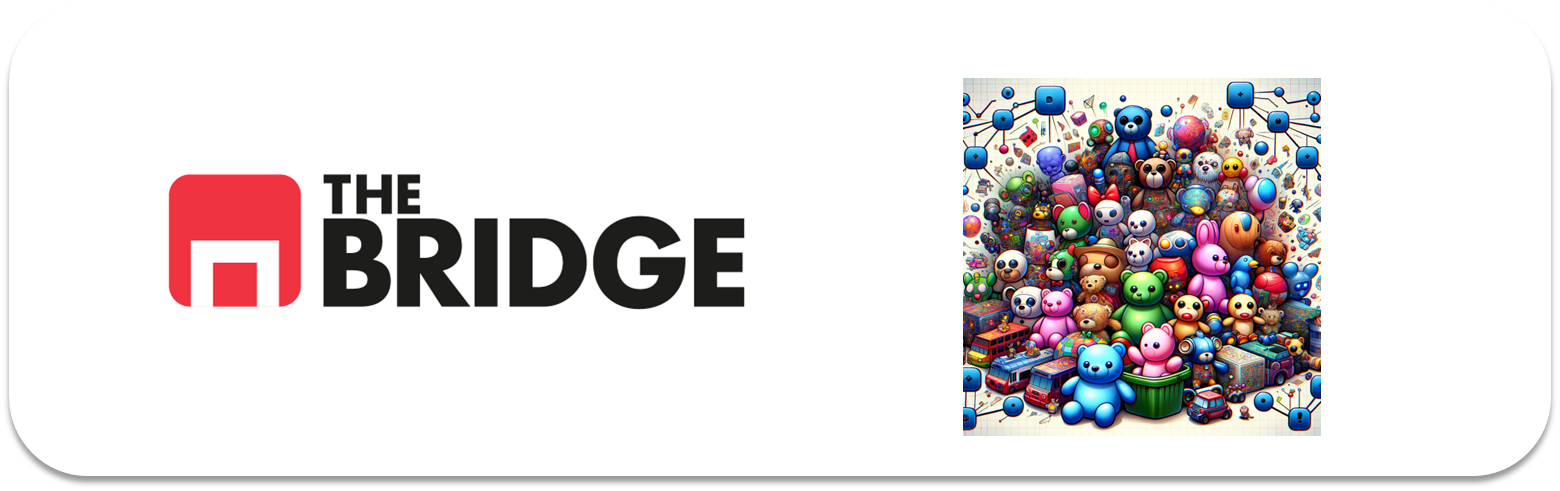

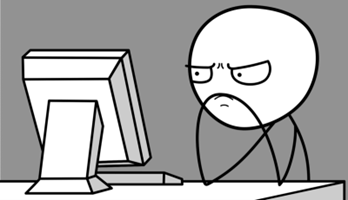

## PRACTICA OBLIGATORIA: K-MEANS

* La práctica obligatoria de esta unidad consiste en un ejercicio de modelado no supervisado sobre imágenes para practicar con el algoritmo k-means. Descarga este notebook en tu ordenador y trabaja en local. Ten en cuenta que tendrás que descar los directorios de imágenes y datos adicionales, si los hubiera.
* Recuerda que debes subirla a tu repositorio personal antes de la sesión en vivo para que puntúe adecuadamente.  
* Recuerda también que no es necesario que esté perfecta, sólo es necesario que se vea el esfuerzo. 
* Esta práctica se resolverá en la sesión en vivo correspondiente y la solución se publicará en el repo del curso. 

### Ejercicio 0

Importa los paquetes y módulos que necesites a lo largo del notebook

In [18]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns

from sklearn.metrics import ConfusionMatrixDisplay, classification_report
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import accuracy_score, precision_score
from sklearn.metrics import mean_squared_error
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LinearRegression
from sklearn.neighbors import KNeighborsRegressor
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
import warnings
warnings.filterwarnings("ignore")

## **#1**

Vamos a trabajar con un dataset también entre los "clásicos" (aunque a veces menos conocido) que es el de rostros Olivetti. Este dataset contiene 400 imágenes en escala de grises de 64 × 64 píxeles de rostros.   


Como en otros datasets de imágenes, estás están "aplanadas" de forma que cada pixel es una feature y por cada imagen hay $64\times 64 = 4096$ features.  

Se fotografiaron 40 personas diferentes (10 veces cada una) y esas fotografías se recogen en el dataset.  

La tarea habitual es entrenar un modelo que pueda predecir qué persona está representada en cada imagen, pero nosotros lo vamos a hacer de forma no supervisada. 



### #1.1


Carga el conjunto de datos usando la función `sklearn.datasets.fetch_olivetti_faces()`. Recuerda que se carga un "diccionario". Muestra su descripción acudiendo a la clave "DESCR".

In [11]:
from sklearn.datasets import fetch_olivetti_faces

faces_data = fetch_olivetti_faces()

#accedemos a la descripción del conjunto de datos
description = faces_data["DESCR"]
print(description)


.. _olivetti_faces_dataset:

The Olivetti faces dataset
--------------------------

`This dataset contains a set of face images`_ taken between April 1992 and 
April 1994 at AT&T Laboratories Cambridge. The
:func:`sklearn.datasets.fetch_olivetti_faces` function is the data
fetching / caching function that downloads the data
archive from AT&T.

.. _This dataset contains a set of face images: https://cam-orl.co.uk/facedatabase.html

As described on the original website:

    There are ten different images of each of 40 distinct subjects. For some
    subjects, the images were taken at different times, varying the lighting,
    facial expressions (open / closed eyes, smiling / not smiling) and facial
    details (glasses / no glasses). All the images were taken against a dark
    homogeneous background with the subjects in an upright, frontal position 
    (with tolerance for some side movement).

**Data Set Characteristics:**

    =================   =====================
    Classes    

### #1.2 

Aunque no lo vas a usar hasta el final de la práctica, muestra el target. Luego cargalo todo en un mismo dataframe (tendrás que añadir el target) y obtén otro dataset con todas las imagenes reordenadas aleatoriamente (emplea por ejemplo el método `sample` del dataframe o el método que tú quieras)

In [12]:
df_faces = pd.DataFrame(faces_data.data)
df_faces["target"] = faces_data.target

#obtenemos otro dataset con imágenes reordenadas aleatoriamente
df_faces_random = df_faces.sample(frac=1, random_state=42)  

print(df_faces_random.head())


            0         1         2         3         4         5         6  \
209  0.198347  0.235537  0.351240  0.409091  0.421488  0.429752  0.500000   
280  0.185950  0.128099  0.115702  0.132231  0.185950  0.268595  0.433884   
33   0.508264  0.603306  0.619835  0.628099  0.657025  0.665289  0.690083   
210  0.136364  0.140496  0.185950  0.280992  0.318182  0.363636  0.409091   
93   0.652893  0.644628  0.652893  0.706612  0.714876  0.719008  0.743802   

            7         8         9  ...      4087      4088      4089  \
209  0.528926  0.524793  0.553719  ...  0.508264  0.524793  0.504132   
280  0.541322  0.570248  0.586777  ...  0.396694  0.409091  0.301653   
33   0.727273  0.743802  0.768595  ...  0.301653  0.305785  0.314050   
210  0.417355  0.438017  0.454545  ...  0.169421  0.206612  0.276859   
93   0.747934  0.747934  0.756198  ...  0.074380  0.074380  0.082645   

         4090      4091      4092      4093      4094      4095  target  
209  0.483471  0.471074  0.285

Los valores obtenidos son las características de las imágenes. Cada fila representa una imagen y cada columna corresponde a una característica específica.

Las columnas 0 a 4095 representan los valores de intensidad de los píxeles en la imagen, normalizados en el rango [0, 1], donde 0 representa la intensidad mínima (negro) y 1 representa la intensidad máxima (blanco).
La columna “target” contiene las etiquetas asociadas a cada imagen. Cada etiqueta numérica representa a una persona diferente en el conjunto de datos. Por ejemplo: la imagen en la fila 209 tiene la etiqueta 20.


### #1.3

Vamos a dividir en train y test, pero OJO RECUERDA QUE EN LOS PROBLEMAS NO SUPERVISADOS NO HAY SPLIT (porque no hay target), aquí lo hacemos para poder comparar posteriormente el clustering con la clasificación (ya que es uan práctica formativa).

Por tanto, divídelo en un conjunto de entrenamiento, un conjunto de validación y un conjunto de pruebas (80-10-10). Dado que el conjunto de datos es bastante pequeño, emplea un muestreo estratificado para asegurarse de que haya el mismo número de imágenes por persona en cada conjunto (estratificando por la columna que contenga el target)

NOTA: No hemos hecho hasta ahora la separación en tres sets, investiga por tu cuenta o bien haz primero un split 90-10 y luego otro split 89-11 sobre el de 80 (para que de los números aproximados), por ejemplo.

In [13]:
#dividimos en 90% train y 10% test
X_train, X_test, y_train, y_test = train_test_split(df_faces.drop(columns=["target"]), df_faces["target"], test_size=0.10, random_state=42)

#dividimos el conjunto de train en 89% train y 11% validacion
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.11, random_state=42)

#imprimimos los tamaños de los conjuntos
print("Tamaño del conjunto de train: ", len(X_train))
print("Tamaño del conjunto de validación: ", len(X_val))
print("Tamaño del conjunto de test: ", len(X_test))


Tamaño del conjunto de train:  320
Tamaño del conjunto de validación:  40
Tamaño del conjunto de test:  40


### #1.4

Crea los pares X,y para train, validation y test.

In [14]:
#creamos los pares X, y para train, validación y test
X_train, y_train = X_train.values, y_train.values
X_val, y_val = X_val.values, y_val.values
X_test, y_test = X_test.values, y_test.values

#imprimimos los tamaños de los conjuntos
print("Tamaño del conjunto de entrenamiento (X_train, y_train): ", X_train.shape, y_train.shape)
print("Tamaño del conjunto de validación (X_val, y_val): ", X_val.shape, y_val.shape)
print("Tamaño del conjunto de pruebas (X_test, y_test): ", X_test.shape, y_test.shape)


Tamaño del conjunto de entrenamiento (X_train, y_train):  (320, 4096) (320,)
Tamaño del conjunto de validación (X_val, y_val):  (40, 4096) (40,)
Tamaño del conjunto de pruebas (X_test, y_test):  (40, 4096) (40,)


***TRAIN (X_train, y_train):***
**X_train:** Contiene 320 imágenes con 4096 características cada una.
**y_train:** Contiene 320 etiquetas correspondientes a las personas en train.

***VALIDACION (X_val, y_val):***
**X_val:** Contiene 40 imágenes con 4096 características cada una.
**y_val:** Contiene 40 etiquetas correspondientes a las personas en validación.


***TEST (X_test, y_test):***
**X_test:** Contiene 40 imágenes con 4096 características cada una.
**y_test:** Contiene 40 etiquetas correspondientes a las personas en test.

Utiliza la siguiente función para visualizar alguna de las caras (observa que tienes que dar la X y la y, usa iloc en ambos datasets)

In [15]:
def plot_faces(faces, labels, n_cols=5):
    faces = faces.reshape(-1, 64, 64)
    n_rows = (len(faces) - 1) // n_cols + 1
    plt.figure(figsize=(n_cols, n_rows * 1.1))
    for index, (face, label) in enumerate(zip(faces, labels)):
        plt.subplot(n_rows, n_cols, index + 1)
        plt.imshow(face, cmap="gray")
        plt.axis("off")
        plt.title(label)
    plt.show()

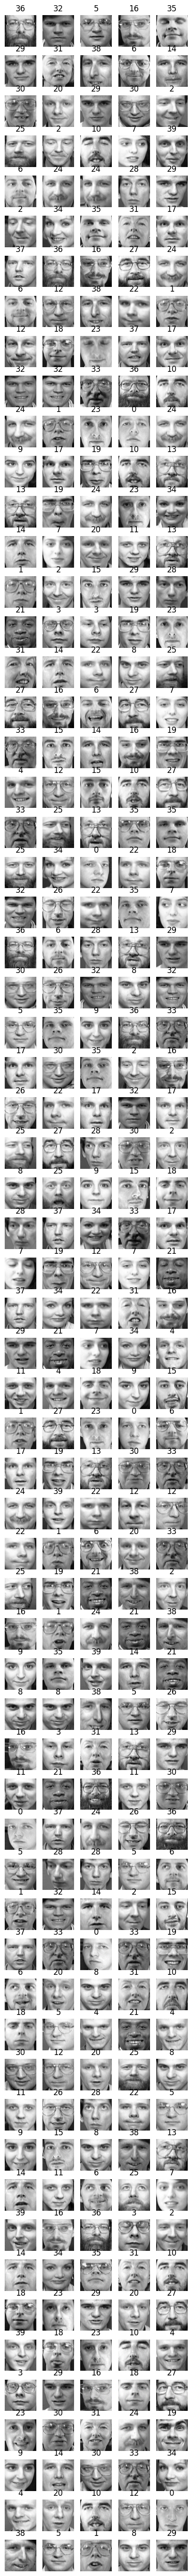

In [16]:
plot_faces(X_train, y_train)

### #1.5

Para acelerar las cosas, reduciremos la dimensionalidad de los datos utilizando PCA (técnica que veremos en el siguiente sprint). Modifica la siguiente celda de forma que las X se correspondan con las que has utilizado en el ejercicio anterior.

In [17]:
from sklearn.decomposition import PCA

pca = PCA(0.99)
X_train_pca = pca.fit_transform(X_train)
X_valid_pca = pca.transform(X_val)
X_test_pca = pca.transform(X_test)

pca.n_components_

221

### 1.6

Aquí viene la parte del león. A continuación, agrupa las imágenes utilizando K-Means sobre el dataset de train reducido en el ejercicio anterior. Emplea el método del máximo de score de silueta para obtener el mejor k, probando con K de 5 en 5 hasta 150. ¿Cuál es el k que proporciona el mejor score de silueta? NOTA: Emplea todas las features (no hace falta seleccionar, y ya están escaladas entre 0 y 1)

In [21]:
#probamos con valores de k desde 5 hasta 150
k_values = np.arange(5, 151, 5)
silhouette_scores = []

In [22]:
#calculamos el score de silueta para cada valor de k, que mide la cohesion dentro de los clusteres y la separacion entre ellos
for k in k_values:
    kmeans = KMeans(n_clusters=k, random_state=42) #creamos el modelo k-means
    kmeans.fit(X_train) #ajustamos el modelo a los datos de train
    labels = kmeans.labels_ #obtenemos las etiquetas de cluster asignadas a cada imagen de train
    silhouette_scores.append(silhouette_score(X_train, labels)) #calculamos el score de silueta para el valor actual de k

In [23]:
#buscamos el valor de k con el máximo score de silueta
best_k = k_values[np.argmax(silhouette_scores)]

print("El valor de k que proporciona el mejor score de silueta es: ", best_k)

El valor de k que proporciona el mejor score de silueta es:  105


Al dividir las imágenes en 105 grupos, se logra una buena cohesión dentro de cada cluster y una separación adecuada entre los clusteres.

### #1.7

Repite el ejercio anterior empleando ahora el método del codo de Inercia. ¿Sale algo más concluyente o que refuerce el anterior resultado?

La inercia mide la dispersión de los puntos dentro de cada cluster. A menor inercia, más compactos serán los clusteres.

In [25]:
#calculamos la inercia para diferentes valores de k
inertia_values = []
for k in range(5, 151, 5): #iteramos a traves de los valores de k de 5 en 5, de 5 a 150
    kmeans = KMeans(n_clusters=k, random_state=42) #creamos una instancia del modelo k-means con el nº actual de clusteres definido por k 
    kmeans.fit(X_train) #ajustamos el modelo a los datos de train
    inertia_values.append(kmeans.inertia_) #calculamos la inercia y la agregamos a la lista inertia_values


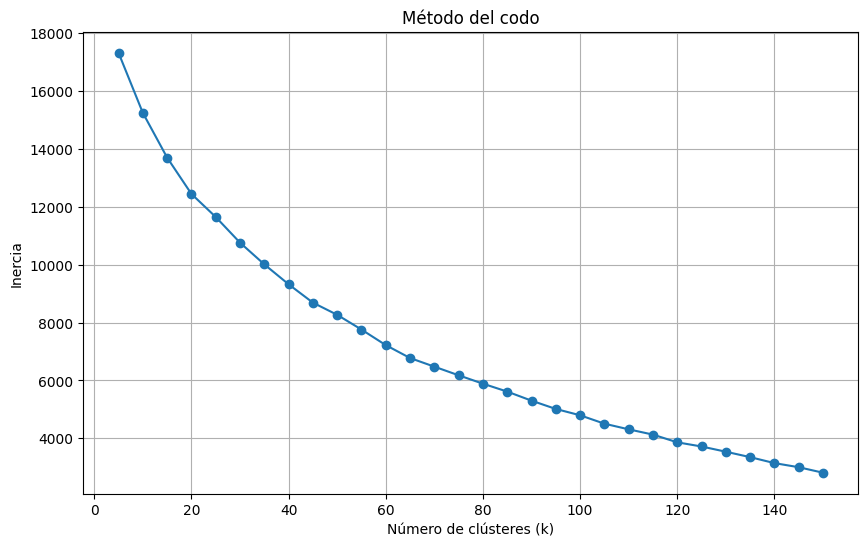

In [27]:
#pintamos la grafica de la inercia en función de k
plt.figure(figsize=(10, 6))
plt.plot(range(5, 151, 5), inertia_values, marker='o')
plt.xlabel("Número de clústeres (k)")
plt.ylabel("Inercia")
plt.title("Método del codo")
plt.grid(True)
plt.show()

### #1.8

Quédate con el k obtenido con el método del score de silueta y asigna el modelo con ese k a una variable `best_model`

In [28]:
best_k = 105  #Valor óptimo de k obtenido con el metodo del score de silueta
best_model = KMeans(n_clusters=best_k, random_state=42)
best_model.fit(X_train)

KMeans(n_clusters=105, random_state=42)

### #1.9

Haz una valoración del método de clustering para el K elegido. Para ello crea un programa que recorra la lista de etiquetas dadas por "best_model" y que, haciendo uso de la función que ya te hemos proporcionado, pinte las caras asignadas a los 10 primeros clústeres. Ojo tendrás que hacer una pequeña adaptación porque las features de entrenamiento no son las features reales (son una "transformación" de estas) y si pasas el X de entrenamiento no verás nada. ¿Ves caras similares?

Clúster 0 :


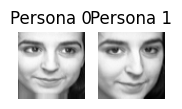

Clúster 1 :


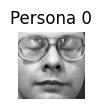

Clúster 2 :


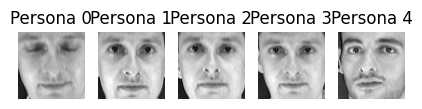

Clúster 3 :


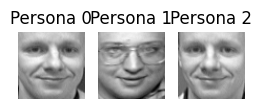

Clúster 4 :


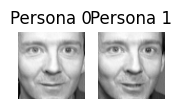

Clúster 5 :


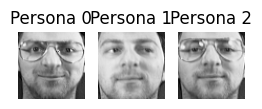

Clúster 6 :


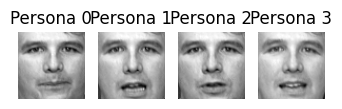

Clúster 7 :


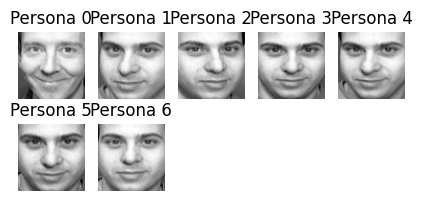

Clúster 8 :


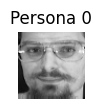

Clúster 9 :


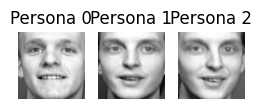

In [30]:
#obtenemos las imágenes originales correspondientes a las etiquetas de cluster
original_faces = X_train.reshape(-1, 64, 64) #con tamaño de 64x64 pixeles

#obtenemos las etiquetas de cluster para las imágenes de train
cluster_labels = best_model.labels_

#creamos un diccionario para almacenar las imágenes por cluster
cluster_images = {i: [] for i in range(best_k)}

#agrupamos las imágenes por cluster
for i, label in enumerate(cluster_labels): #iteramos a traves de las etiquetas del cluster
    cluster_images[label].append(original_faces[i]) #agregamos la imagen a la etiqueta del cluster correspondiente

#mostramos las caras asignadas a los 10 primeros clusteres
for i in range(10): #iteramos a traves de los 10 primeros clusteres
    print("Clúster", i, ":")
    #mostramos las 10 primeras imagenes asociadas a cada cluster
    plot_faces(np.array(cluster_images[i])[:10], [f"Persona {j}" for j in range(10)])

## **#2**


### #2.1


Continuando con el conjunto de datos de caras Olivetti, entrena un clasificador para predecir qué persona está representada en cada imagen, y evalúalo en el conjunto de validación. Utiliza un RandomForest con 150 submodelos o estimadores (y el resto de hiperparámetros déjalos a su valor por defecto)

In [33]:
data = fetch_olivetti_faces()
X, y = data.data, data.target

#dividimos en conjuntos de train y validacion
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)

#creamos y entrenamos el clasificador Random Forest con 150 submodelos
forest = RandomForestClassifier(n_estimators=150, random_state=42)
forest.fit(X_train, y_train) #ajustamos el modelo a los datos de train y sus etiquetas

#predecimos en el conjunto de validacion
y_pred = forest.predict(X_val)

#evaluamos el rendimiento
accuracy = accuracy_score(y_val, y_pred) #calculamos la precision comparando las etiquetas verdaderas en el conjunto de validacion con las predicciones realizadas por el modelo
print("Precisión en el conjunto de validación: ", accuracy)

Precisión en el conjunto de validación:  0.9125


La precisión del 91% en el conjunto de validación indica que el clasificador Random Forest está haciendo predicciones casi perfectas para las imágenes de caras.

### #2.2

Utiliza K-Means como una herramienta de reducción de dimensionalidad y entrena un clasificador en el conjunto reducido. Para ello emplea el método transform de manera que ahora las features de entrada sean las distancias de cada punto a los centroides del modelo "best_model" de la parte anterior. Por ejemplo:
```python
X_train_reduced = best_model.transform(X_train_pca) 
```


Ojo lo tienes que aplicar a todos los datasets. Luego vuelve a entrenar un RandomForest sobre este dataset y evalualo contra el dataset de validacion.

In [34]:
#reducimos dimensionalidad con k-means
X_train_reduced = best_model.transform(X_train) #usamos el modelo bestmodel para transformar los datos de x_train
X_val_reduced = best_model.transform(X_val) #obtenemos las distancias de cada imagen a los centroides de los clusteres

#entrenamos el clasificador random forest
forest_reduced = RandomForestClassifier(n_estimators=150, random_state=42) #creamos una instancia del modelo random forest con 150 submodelos
forest_reduced.fit(X_train_reduced, y_train) #ajustamos el modelo a los datos de train reducidos

#evaluamos en el conjunto de validación
accuracy_reduced = forest_reduced.score(X_val_reduced, y_val) #calculamos la precision comparando las etiquetas verdaderas en el conjunto de validacion con las predicciones del modelo entrenado con las distancias reducidas
print("Precisión en el conjunto de validación (con dimensionalidad reducida): ", accuracy_reduced)

Precisión en el conjunto de validación (con dimensionalidad reducida):  0.7875


La precisión en el conjunto de validación es de un 78.75%, que es un resultado bastante sólido.

### #2.3 EXTRA VOLUNTARIO

Busca el número de clusters k que generen un algoritmo kmeans que a su vez sus distancias a los centroides sean las features de un clasificador RandomForest y que permita al clasificador obtener el mejor rendimiento: ¿Qué rendimiento puedes alcanzar? (en terminos de Accuracy)

*Debemos buscar diferentes valores de k utilizando el método del codo y luego evaluar el rendimiento del clasificador Random Forest para seleccionar el número óptimo de clusteres.*